In [1]:
library("rwwa")

Loading required package: extRemes

Loading required package: Lmoments

Loading required package: distillery


Attaching package: ‘extRemes’


The following objects are masked from ‘package:stats’:

    qqnorm, qqplot


Loading required package: plyr


Attaching package: ‘plyr’


The following object is masked from ‘package:distillery’:

    is.formula


Loading required package: copula

Loading required package: MASS



# Choose an appropriate statistical distribution

In [ ]:
# load your annual time series & merge with GMST covariates (matched by 'year' because this appears in both data.frames)
df <- merge(read.table("gmst.txt", col.names = c("year", "gmst")), read.csv("ts_era5.csv"))
df$gmst <- df$gmst - df$gmst[df$year == 2024]

In [ ]:
png("fig_timeseries.png", height = 360, width = 360*1.5); par(mar = c(2,4,1,1), lwd = 2); {
    # prep_window(c(1,1), w = 6, lwd = 2, mar = c(2,4,1,1))
    plot(df$year-0.5, df$tmax, type = "s", lwd = 2, xlab = "", ylab = "Annual max temperature (degC)")
    points(2024,df$tmax[df$year == 2024], pch = 21, bg = "magenta")
}; dev.off()

In [157]:
png("fig_densities.png", height = 360, width = 360*1.5); par(mar = c(4,4,1,1), lwd = 2); {
    plot(density(df$tmax), ylim = c(0,0.175), lwd = 3, xlab = "Annual max temperature (degC)", main = "")
    rug(df$tmax, lwd = 2)
    
    # fit a quick *STATIONARY* distribution to get an idea of which model might be a good fit
    pars_normal <- fitdistr(df$tmax, "normal")
    pars_gev <- fevd(df$tmax)$results$par
    
    lines(x <- seq(15,35,0.1), dnorm(x, pars_normal$est["mean"], pars_normal$est["sd"]), col = "blue", lwd = 2)
    lines(x, devd(x, loc = pars_gev["location"], scale = pars_gev["scale"], shape = pars_gev["shape"]), col = "red3", lwd = 2)
    
    legend("topleft", c("Normal", "GEV"), col = c("blue", "red3"), lty = 1, lwd = 2, bty = "n")
}; dev.off()

png 
  2

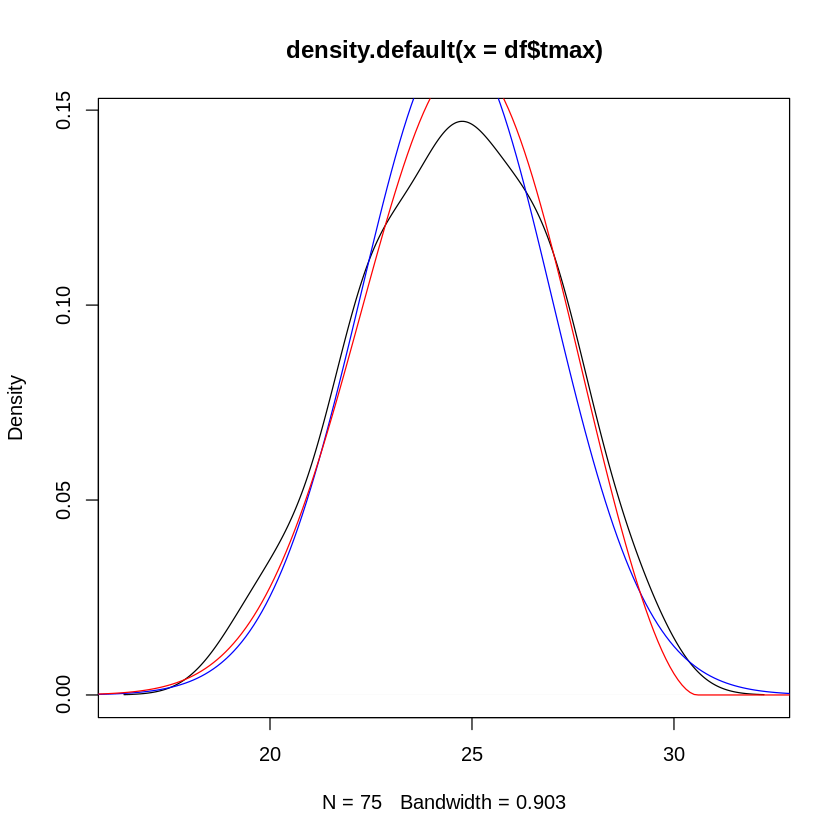

In [3]:
# plot the density of the data - is it approximately normally distributed, or skewed?
plot(density(df$tmax))

# fit a quick *STATIONARY* distribution to get an idea of which model might be a good fit
pars_normal <- fitdistr(df$tmax, "normal")
pars_gev <- fevd(df$tmax)$results$par

lines(x <- seq(15,35,0.1), dnorm(x, pars_normal$est["mean"], pars_normal$est["sd"]), col = "blue")
lines(x, devd(x, loc = pars_gev["location"], scale = pars_gev["scale"], shape = pars_gev["shape"]), col = "red")

# if neither fits well, a transformation may be necessary (eg. log-transformation for precipitation)

In [63]:
# try fitting different distributions to compare which actually fits better
mdl_gev <- fit_ns(dist = "gev", type = "shift", data = df, varnm = "tmax", covnm = "gmst")
mdl_norm <- fit_ns(dist = "norm", type = "shift", data = df, varnm = "tmax", covnm = "gmst")

# use AIC to identify the model that fits better (lower score is better)
aic(mdl_gev)
aic(mdl_norm)

[1] 342.863

[1] 344.2019

# Fit the chosen linear model & define the factual / counterfactual climates

In [11]:
mdl <- fit_ns("gev", "shift", df, varnm = "tmax", covnm = "gmst")

cov_factual <- data.frame(gmst = df$gmst[df$year == 2024])
cov_counterfactual <- data.frame(gmst = df$gmst[df$year == 2024] - 1.3)

## Check that the model is a good fit to the data

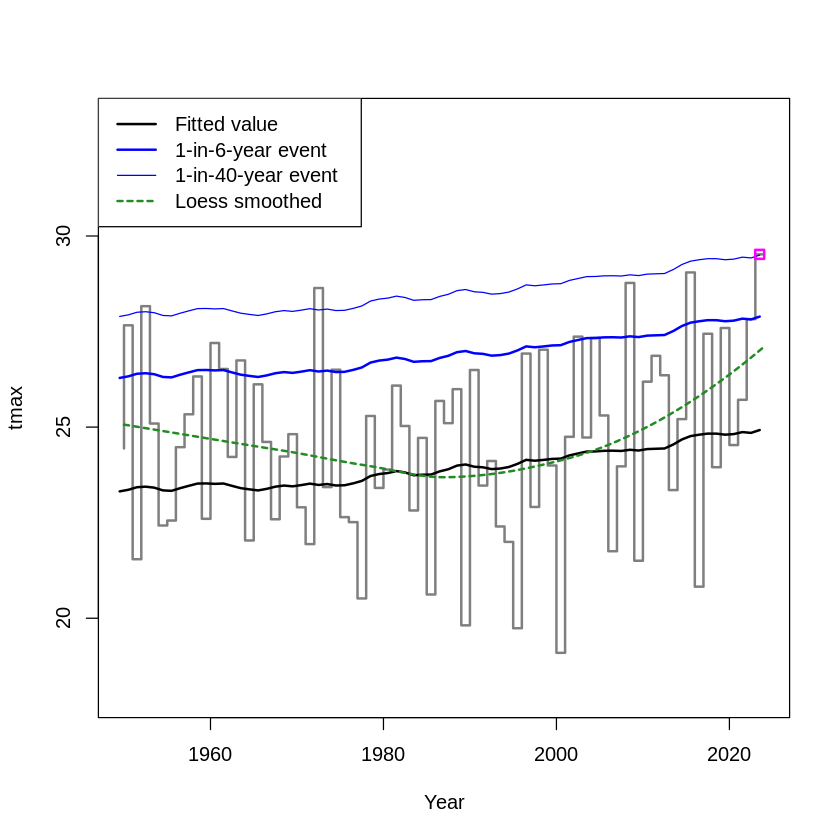

In [19]:
# what does the fitted trend look like over time?
plot_trend(mdl, add_loess = T, ylim = c(18,33))

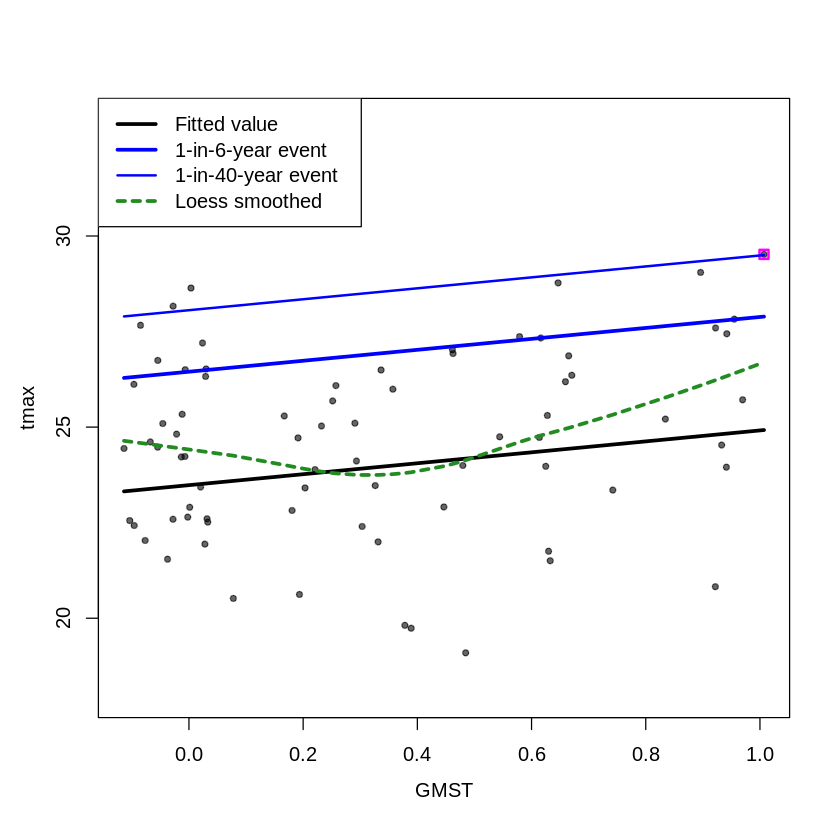

In [20]:
# what does the fitted trend look like vs GMST?
plot_covtrend(mdl, xcov = "gmst", add_loess = T, ylim = c(18,33))

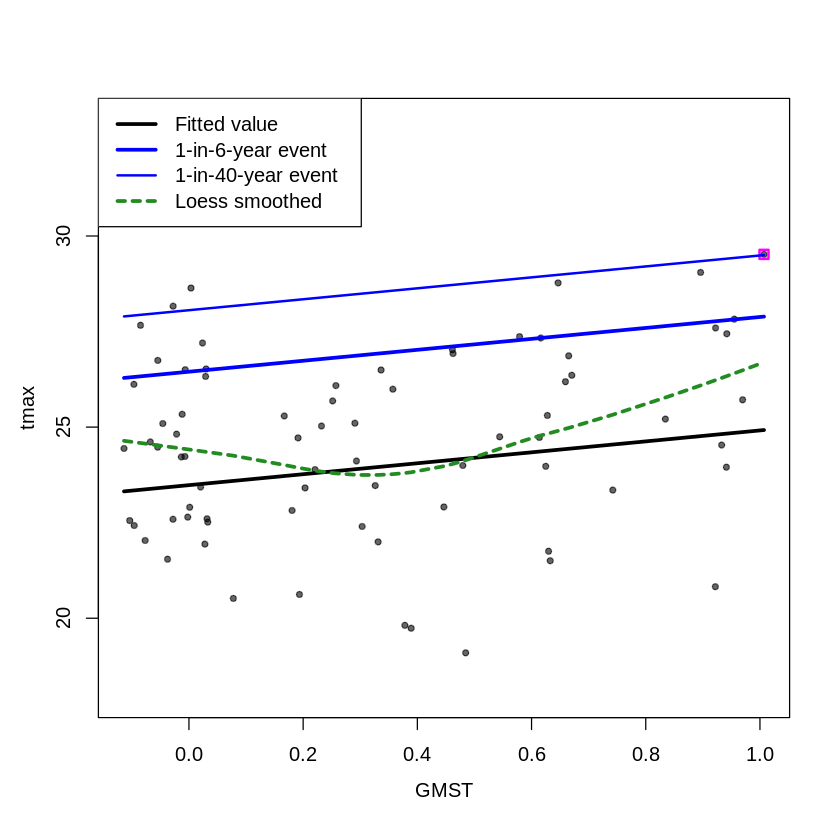

In [21]:
# what does the fitted trend look like vs GMST?
plot_covtrend(mdl, xcov = "gmst", add_loess = T, ylim = c(18,33))

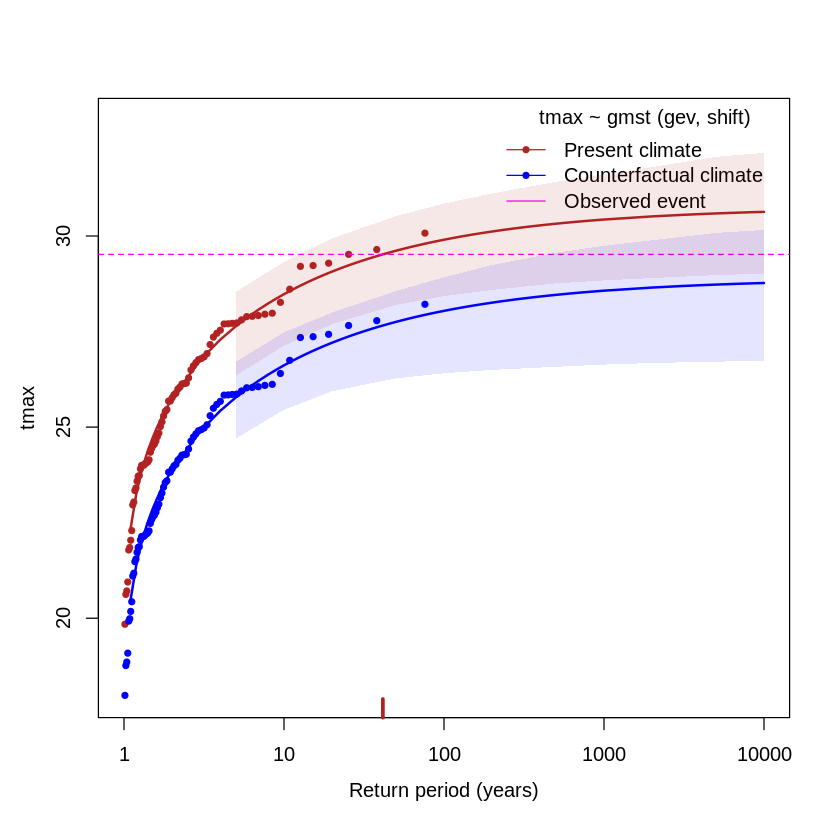

In [45]:
# How well does the model fit the data?
plot_returnlevels(mdl, cov_f = cov_factual, cov_cf = cov_counterfactual, ylim = c(18,33))

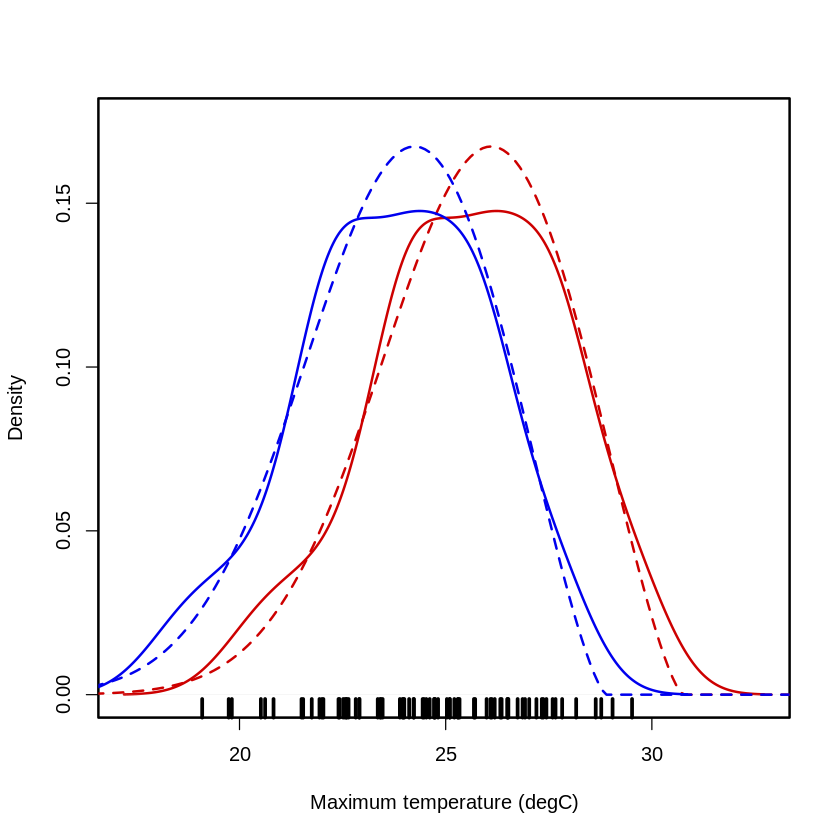

In [129]:
# the 'rwwa' package has a built-in function to transform all points into the factual or counterfactual climate
y_factual <- stransform(mdl, fixed_cov = cov_factual)
y_counterfactual <- stransform(mdl, fixed_cov = cov_counterfactual)

# it can also extract the model parameters for a fixed value of the covariates
pars_factual <- ns_pars(mdl, fixed_cov = cov_factual)
pars_counterfactual <- ns_pars(mdl, fixed_cov = cov_counterfactual)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# we can therefore plot the density of the temperatures as they would have been in today's climate, or in the counterfactual climate
par(lwd = 2)
plot(density(y_factual), col = "red3", ylim = c(0,0.175), main = "", xlab = "Maximum temperature (degC)")
lines(x <- seq(15,35,0.1), devd(x, loc = pars_factual$loc, scale = pars_factual$scale, shape = pars_factual$shape),
     type = "l", col = "red3", lty = 2)

lines(density(y_counterfactual), col = "blue2")
lines(x <- seq(15,35,0.1), devd(x, loc = pars_counterfactual$loc, scale = pars_counterfactual$scale, shape = pars_counterfactual$shape),
     type = "l", col = "blue2", lty = 2)

# add ticks to show temperatures that were actually observed
rug(df$tmax, lwd = 3)

# Get the fitted model parameters \& results

In [99]:
# use the built-in function to bootstrap the model results
boot_res <- boot_ci(mdl, cov_f = cov_factual, cov_cf = cov_counterfactual)

In [130]:
# save as a .csv to look at them later
write.csv(boot_res, "res-obs_era5.csv")

# Produce some figures for the report

In [40]:
png("fig_obs-trend_era5.png"); {
    plot_trend(mdl, add_loess = T, ylim = c(18,33), ylab = "Maximum temperature (degC)", lwd = 2)
}; dev.off()

png 
  2

In [41]:
png("fig_obs-gmsttrend_era5.png"); {
    plot_covtrend(mdl, xcov = "gmst", add_loess = T, ylim = c(18,33), ylab = "Maximum temperature (degC)", lwd = 2)
}; dev.off()

png 
  2

In [44]:
png("fig_obs-returnlevels_era5.png"); {
    plot_returnlevels(mdl, cov_f = cov_factual, cov_cf = cov_counterfactual, ylim = c(18,33), ylab = "Maximum temperature (degC)",
                     legend_labels = c("2025", "Preindustrial"))
}; dev.off()

png 
  2